In [ ]:
# === Cell 0: Setup (paths, imports) ===
import json
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

from emlearn import convert as eml_convert   # emlearn converter

# --- Paths ---
DATA_ROOT   = Path("dataset")
NORMAL_DIR  = DATA_ROOT/"normal_data"
ANOM_DIR    = DATA_ROOT/"anomalie_data"
OUT_DIR     = Path("project_models_rf")
CODEGEN_DIR = OUT_DIR/"codegen"
OUT_DIR.mkdir(exist_ok=True, parents=True)
CODEGEN_DIR.mkdir(exist_ok=True, parents=True)

# --- Signal/Window params (match MCU) ---
FS_HZ   = 200
WIN     = 128
HOP     = 64
N_CH    = 3

# Feature layout: mean + std per axis => 6 dims
FEATS_PER_CH = 2
FEAT_DIM     = N_CH * FEATS_PER_CH   # 6

np.random.seed(7)
print("Output:", CODEGEN_DIR)



Output: project_models_rf/codegen


In [ ]:
# === Cell 1: Load CSVs (expects columns timestamp_ms, ax_raw, ay_raw, az_raw, label) ===
def load_folder(folder: Path, label: str):
    rows = []
    for f in sorted(folder.glob("*.csv")):
        df = pd.read_csv(f)
        df = df.rename(columns={
            'timestamp_ms':'time_ms',
            'ax_raw':'Ax', 'ay_raw':'Ay', 'az_raw':'Az',
            'label':'label'
        })
        keep = ['time_ms','Ax','Ay','Az']
        for k in keep:
            if k not in df.columns:
                raise ValueError(f"Column {k} missing in {f}")
        df['label']    = label
        df['filename'] = f.stem
        rows.append(df[['label','time_ms','Ax','Ay','Az','filename']])
    if rows:
        return pd.concat(rows, ignore_index=True)
    return pd.DataFrame(columns=['label','time_ms','Ax','Ay','Az','filename'])

ds_norm = load_folder(NORMAL_DIR, "normal")
ds_anom = load_folder(ANOM_DIR,   "anomalie")

print("Normals:", ds_norm.shape, "files:", ds_norm['filename'].nunique())
print("Anomalies:", ds_anom.shape, "files:", ds_anom['filename'].nunique())
display(ds_norm.head(3))




Normals: (260337, 6) files: 1
Anomalies: (260000, 6) files: 1


,label,time_ms,Ax,Ay,Az,filename
0,normal,0,-104,1011,75,normal_log_2025_11_05_17:47:12
1,normal,5,-77,1019,102,normal_log_2025_11_05_17:47:12
2,normal,10,-127,1109,114,normal_log_2025_11_05_17:47:12


In [ ]:
# === Cell 2: Axis-wise normalization parameters (reusable on MCU) ===
AXES = ['Ax','Ay','Az']

# compute mean/std from RAW NORMAL data only
axis_mean = ds_norm[AXES].astype(np.float64).mean(axis=0).values
axis_std  = ds_norm[AXES].astype(np.float64).std(axis=0, ddof=0).values
axis_std  = np.where(axis_std==0.0, 1e-6, axis_std)  # avoid div/0

print("Axis means (Ax,Ay,Az):", axis_mean)
print("Axis stds  (Ax,Ay,Az):", axis_std)

def zscore_df_raw(df):
    Z = df[AXES].astype(np.float64).values
    Z = (Z - axis_mean) / axis_std
    out = df.copy()
    out[AXES] = Z.astype(np.float32)
    return out




Axis means (Ax,Ay,Az): [  -2.13214795 1057.51379558  -58.29425706]
Axis stds  (Ax,Ay,Az): [176.23116204 277.850411   233.24407012]


In [ ]:
# === Cell 3: Windowing + 6-feature extraction (mean & std per axis) ===
def frame_indices(n, win=WIN, hop=HOP):
    i = 0
    while i + win <= n:
        yield i, i+win
        i += hop

def features_from_window(win3):   # (WIN,3) -> (6,)
    X = []
    for k in range(3):
        x = win3[:, k].astype(np.float32)
        mu  = float(np.mean(x))
        sd  = float(np.std(x, ddof=0))
        X.extend([mu, sd])
    return np.array(X, dtype=np.float32)

def featurize_by_file_axis_z(df):
    feats, labels = [], []
    for fname, part in df.groupby('filename', sort=False):
        partz = zscore_df_raw(part)                 # normalize RAW per axis
        arr = partz[['Ax','Ay','Az']].values       # shape (N,3), float32
        for i0, i1 in frame_indices(len(arr)):
            win = arr[i0:i1]
            feats.append(features_from_window(win)) # 6 features
            labels.append(part['label'].iloc[0])
    X = np.vstack(feats).astype(np.float32) if feats else np.zeros((0, FEAT_DIM), np.float32)
    y = np.array(labels)
    return X, y

Xn, yn = featurize_by_file_axis_z(ds_norm)
Xa, ya = featurize_by_file_axis_z(ds_anom)

print("Xn:", Xn.shape, "| Xa:", Xa.shape)





Xn: (4066, 6) | Xa: (4061, 6)


In [ ]:
# === Cell 4: Build dataset for 2-class classification: 1=normal, 0=anomalie ===
X = np.vstack([Xn, Xa]).astype(np.float32)
y = np.concatenate([
    np.ones(len(Xn), dtype=int),     # normal
    np.zeros(len(Xa), dtype=int)     # anomalie
])

print("Full dataset:", X.shape, "labels:", np.bincount(y))

# train/heldout split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=7, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)





Full dataset: (8127, 6) labels: [4061 4066]
Train: (5688, 6) Test: (2439, 6)


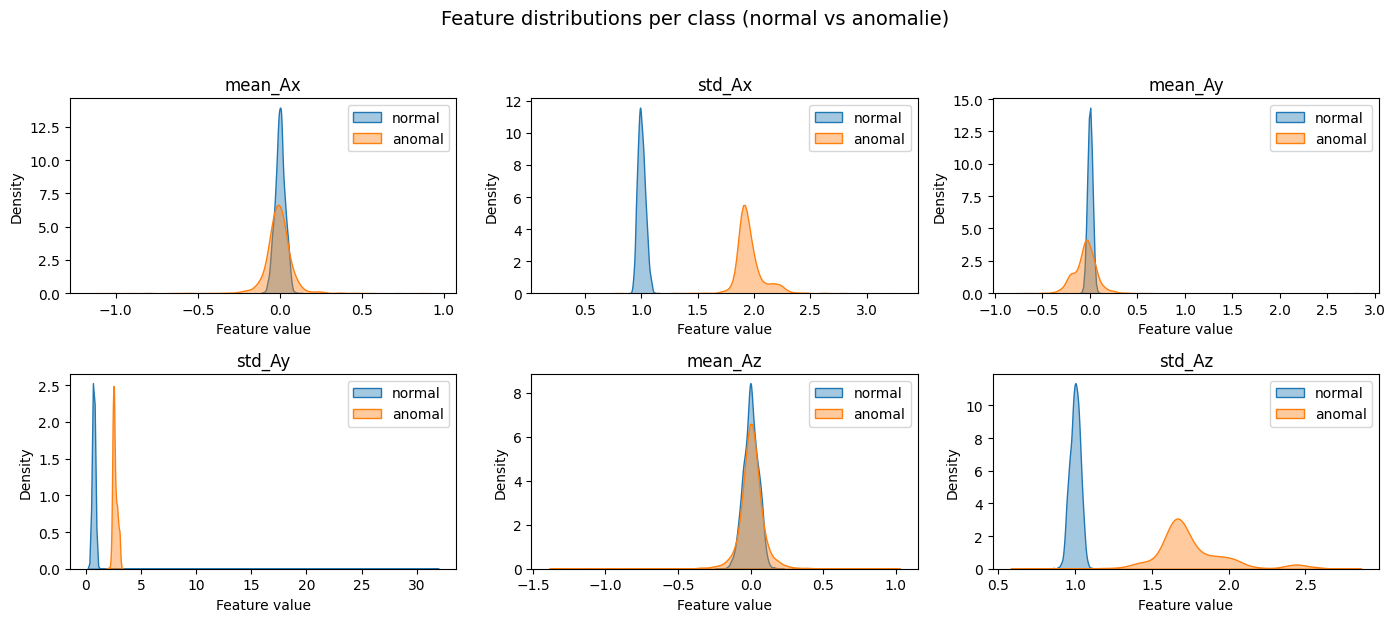

In [8]:
# === Cell X: Visualize feature distributions (normal vs anomal) ===
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(14, 6))
titles = ["mean_Ax", "std_Ax", "mean_Ay", "std_Ay", "mean_Az", "std_Az"]

for i in range(6):
    plt.subplot(2, 3, i + 1)
    sns.kdeplot(X[y == 1, i], label="normal", fill=True, alpha=0.4)
    sns.kdeplot(X[y == 0, i], label="anomal", fill=True, alpha=0.4)
    plt.title(titles[i])
    plt.xlabel("Feature value")
    plt.ylabel("Density")
    plt.legend()

plt.suptitle("Feature distributions per class (normal vs anomalie)", fontsize=14, y=1.03)
plt.tight_layout()
plt.show()



In [9]:
# === Cell 5: Train RandomForest (balanced, compact) ===
rf = RandomForestClassifier(
    n_estimators=60,
    max_depth=8,
    min_samples_leaf=2,
    class_weight='balanced',   # helpful if classes imbalanced
    random_state=7,
    n_jobs=-1
)
rf.fit(X_train, y_train)

yhat = rf.predict(X_test)
proba = rf.predict_proba(X_test)[:, 1] if hasattr(rf, "predict_proba") else None

print("Confusion (rows=true [0,1] anomal,normal):\n", confusion_matrix(y_test, yhat, labels=[0,1]))
print(classification_report(y_test, yhat, target_names=['anomalie','normal']))

if proba is not None:
    try:
        auc = roc_auc_score(y_test, proba)
        print("ROC-AUC:", auc)
    except Exception as e:
        print("AUC error:", e)
        


Confusion (rows=true [0,1] anomal,normal):
 [[1219    0]
 [   0 1220]]
              precision    recall  f1-score   support

    anomalie       1.00      1.00      1.00      1219
      normal       1.00      1.00      1.00      1220

    accuracy                           1.00      2439
   macro avg       1.00      1.00      1.00      2439
weighted avg       1.00      1.00      1.00      2439

ROC-AUC: 1.0


In [10]:
import joblib

# Speichere das trainierte RandomForest-Modell
joblib.dump(rf, "rf_model.joblib")
print("✅ Saved trained RandomForest model as rf_model.joblib")



✅ Saved trained RandomForest model as rf_model.joblib


In [ ]:
# === Cell 6: Export axis scaler for C (axis_scaler.h) ===
axis_h = CODEGEN_DIR / "axis_scaler.h"
with open(axis_h, "w") as f:
    f.write("#pragma once\n#include <stdint.h>\n\n")
    f.write("/* Autogenerated: axis-wise z-score on raw Ax,Ay,Az */\n")
    f.write("static const float AXIS_MEAN[3] = { %.9g, %.9g, %.9g };\n" % tuple(axis_mean))
    f.write("static const float AXIS_STD[3]  = { %.9g, %.9g, %.9g };\n"  % tuple(axis_std))
print("✅ Wrote:", axis_h)




✅ Wrote: project_models_rf/codegen/axis_scaler.h


In [12]:
# === Cell 7: Export RandomForest to C with emlearn (final fixed) ===
from emlearn import convert as eml_convert
import json

# Convert the trained sklearn RandomForest to C
cmodel = eml_convert(
    rf,
    method='inline',   # code generation method (inline = header only)
    dtype='float'      # model expects float features
)

# Correct usage: positional arguments, NOT named
model_h = CODEGEN_DIR / "model.h"
cmodel.save("rf_model", str(model_h))   # <-- name first, then filename

# Write metadata (optional, for reference on MCU)
info_json = {
    "fs_hz": FS_HZ,
    "win": WIN,
    "hop": HOP,
    "feat_dim": FEAT_DIM,
    "class_order": rf.classes_.tolist(),  # [0,1] -> [anomalie, normal]
}
with open(CODEGEN_DIR / "model_info.json", "w") as f:
    json.dump(info_json, f, indent=2)

print("✅ Wrote:", model_h)
print("Classes:", rf.classes_)



✅ Wrote: project_models_rf/codegen/model.h
Classes: [0 1]


In [34]:
# === Cell 8 (optional): Simple cross-check on a few windows ===
idx = np.random.choice(len(X_test), size=min(20, len(X_test)), replace=False)
for i in idx:
    p = rf.predict_proba([X_test[i]])[0,1]
    print(f"y={y_test[i]}  p(normal)={p:.3f}  -> pred={int(p>=0.5)}")
    


y=0  p(normal)=0.000  -> pred=0
y=0  p(normal)=0.000  -> pred=0
y=0  p(normal)=0.000  -> pred=0
y=1  p(normal)=1.000  -> pred=1
y=1  p(normal)=1.000  -> pred=1
y=0  p(normal)=0.000  -> pred=0
y=0  p(normal)=0.000  -> pred=0
y=0  p(normal)=0.000  -> pred=0
y=0  p(normal)=0.000  -> pred=0
y=1  p(normal)=1.000  -> pred=1
y=1  p(normal)=0.967  -> pred=1
y=1  p(normal)=1.000  -> pred=1
y=0  p(normal)=0.000  -> pred=0
y=1  p(normal)=1.000  -> pred=1
y=1  p(normal)=1.000  -> pred=1
y=1  p(normal)=1.000  -> pred=1
y=0  p(normal)=0.000  -> pred=0
y=0  p(normal)=0.000  -> pred=0
y=1  p(normal)=1.000  -> pred=1
y=1  p(normal)=1.000  -> pred=1
